In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from os import listdir

In [ ]:
import keras
from keras.preprocessing import image
from keras import backend as K
from keras.layers import Input

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.applications import InceptionV3, DenseNet121, ResNet50, Xception, VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
dir_root = "/content/drive/My Drive/Dataset/tomato/"

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
default_image_size = tuple((299, 299))

image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(dir_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{dir_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{dir_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:100]:
                image_directory = f"{dir_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Image loading completed
CPU times: user 96 µs, sys: 8 µs, total: 104 µs
Wall time: 109 µs


In [ ]:
len(image_list)

700

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)
label_binarizer.classes_

array(['Tomato___Bacterial_spot', 'Tomato___Early_blight',
       'Tomato___Late_blight', 'Tomato___Leaf_Mold',
       'Tomato___Spider_mites Two-spotted_spider_mite',
       'Tomato___Target_Spot', 'Tomato___healthy'], dtype='<U45')

In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    np_image_list,
    image_labels,
    test_size=0.2,
    stratify=image_labels,
    random_state = 42)

In [ ]:
len(x_train), len(x_test), len(y_train), len(y_test)

(560, 140, 560, 140)

In [ ]:
aug = ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    zoom_range = 0.2)

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('/content/drive/My Drive/Model/xception_tomato.h5')
model2 = load_model('/content/drive/My Drive/Model/inceptionv3_tomato.h5')
model3 = load_model('/content/drive/My Drive/Model/vgg16_tomato.h5')

In [ ]:
#@title Ensemble Stacking


In [ ]:
models = [model1, model2, model3]

In [ ]:
model1._name = "inception"
model2._name = "xception"
model3._name = "vgg16"

In [ ]:
for layer in model1.layers:
  layer.trainable = False
  layer._name = layer._name + str("_inception")

for layer in model2.layers:
  layer.trainable = False
  layer._name = layer._name + str("_xception")

for layer in model3.layers:
  layer.trainable = False
  layer._name = layer._name + str("_vgg16")

In [ ]:
#@title Stacking ensemble keras

In [ ]:
models = [model1, model2, model3]
model_input = tf.keras.Input(shape=(299, 299, 3))
model_outputs = [model(model_input) for model in models]
combinedOutput = layers.concatenate(model_outputs)
x = layers.Dense(512, activation="relu")(combinedOutput)
x = layers.Dense(n_classes, activation="softmax")(x)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=x)
print(ensemble_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception (Functional)         (None, 7)            21914159    ['input_2[0][0]']                
                                                                                                  
 xception (Functional)          (None, 7)            22855463    ['input_2[0][0]']                
                                                                                                  
 vgg16 (Functional)             (None, 7)            14980935    ['input_2[0][0]']          

In [ ]:
ensemble_model.compile (optimizer = Adam(learning_rate=0.0001),
               loss = tf.keras.losses.CategoricalCrossentropy(),
               metrics = ['accuracy'])

In [ ]:
procces = ensemble_model.fit(
    x_train, y_train,
    validation_data=(x_test,y_test),
    steps_per_epoch=len(x_train) // 32,
    epochs=20,
    verbose=1)

Epoch 1/20
17/17 [==============================] - 25s 1s/step - loss: 1.9112 - accuracy: 0.1929 - val_loss: 1.8616 - val_accuracy: 0.4214
Epoch 2/20
17/17 [==============================] - 16s 960ms/step - loss: 1.8193 - accuracy: 0.7464 - val_loss: 1.7711 - val_accuracy: 0.9429
Epoch 3/20
17/17 [==============================] - 15s 908ms/step - loss: 1.7299 - accuracy: 0.9750 - val_loss: 1.6824 - val_accuracy: 0.9786
Epoch 4/20
17/17 [==============================] - 15s 897ms/step - loss: 1.6424 - accuracy: 0.9875 - val_loss: 1.5957 - val_accuracy: 0.9929
Epoch 5/20
17/17 [==============================] - 15s 905ms/step - loss: 1.5563 - accuracy: 0.9946 - val_loss: 1.5105 - val_accuracy: 0.9929
Epoch 6/20
17/17 [==============================] - 16s 925ms/step - loss: 1.4719 - accuracy: 0.9946 - val_loss: 1.4263 - val_accuracy: 0.9929
Epoch 7/20
17/17 [==============================] - 16s 931ms/step - loss: 1.3881 - accuracy: 0.9946 - val_loss: 1.3434 - val_accuracy: 0.9929
Ep

In [ ]:
scores = ensemble_model.evaluate(x_test, y_test, batch_size=32)
print(f"Test Accuracy: {scores[1]*100}")

5/5 [==============================] - 3s 505ms/step - loss: 0.4520 - accuracy: 0.9929
Test Accuracy: 99.28571581840515


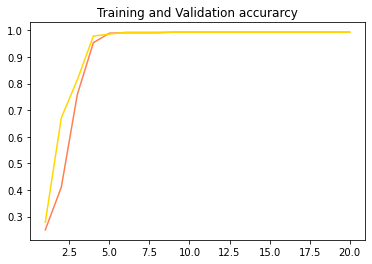

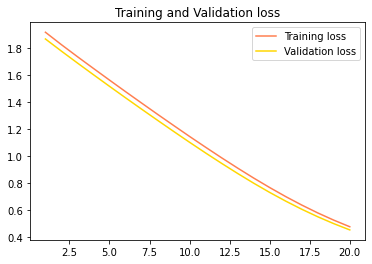

In [ ]:
acc = procces.history['accuracy']
val_acc = procces.history['val_accuracy']
loss = procces.history['loss']
val_loss = procces.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'coral', label='Training accurarcy')
plt.plot(epochs, val_acc, 'gold', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'coral', label='Training loss')
plt.plot(epochs, val_loss, 'gold', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
pred = ensemble_model.predict(x_test, batch_size=32, verbose=2)
model_predicted = np.argmax(pred, axis = 1)

5/5 - 4s - 4s/epoch - 867ms/step


In [ ]:
labels = label_binarizer.classes_

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), model_predicted, target_names=labels))

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       1.00      1.00      1.00        20
                        Tomato___Early_blight       1.00      1.00      1.00        20
                         Tomato___Late_blight       1.00      1.00      1.00        20
                           Tomato___Leaf_Mold       1.00      1.00      1.00        20
Tomato___Spider_mites Two-spotted_spider_mite       0.95      1.00      0.98        20
                         Tomato___Target_Spot       1.00      1.00      1.00        20
                             Tomato___healthy       1.00      0.95      0.97        20

                                     accuracy                           0.99       140
                                    macro avg       0.99      0.99      0.99       140
                                 weighted avg       0.99      0.99      0.99       140



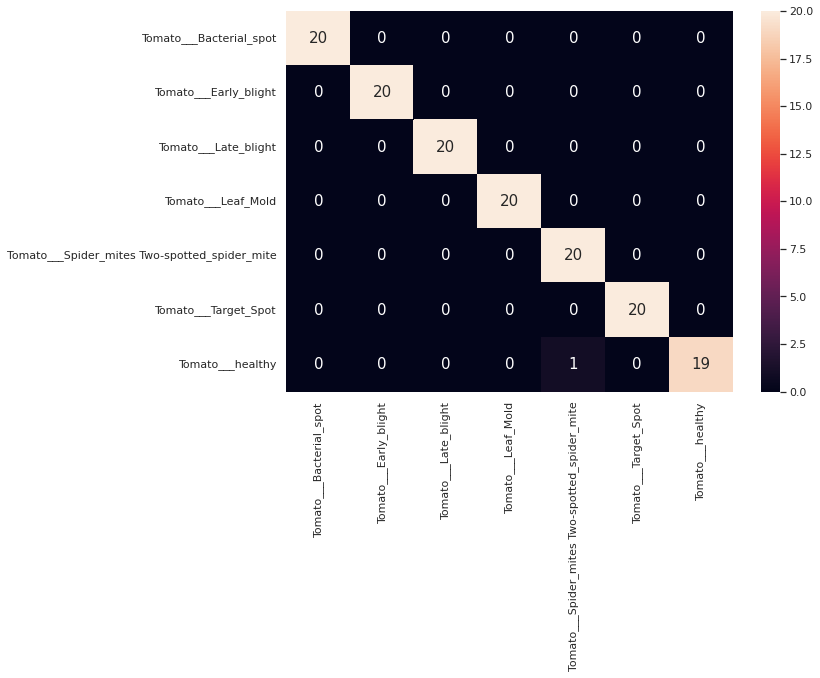

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

model_cm = confusion_matrix(np.argmax(y_test, axis=1), model_predicted)
#Visualisasi Confusion Matrix
model_df_cm = pd.DataFrame(model_cm, labels, labels)
plt.figure(figsize = (10,7))
sn.set(font_scale=1) #for label size
sn.heatmap(model_df_cm, annot=True, annot_kws={"size": 15}) # font size
plt.show()

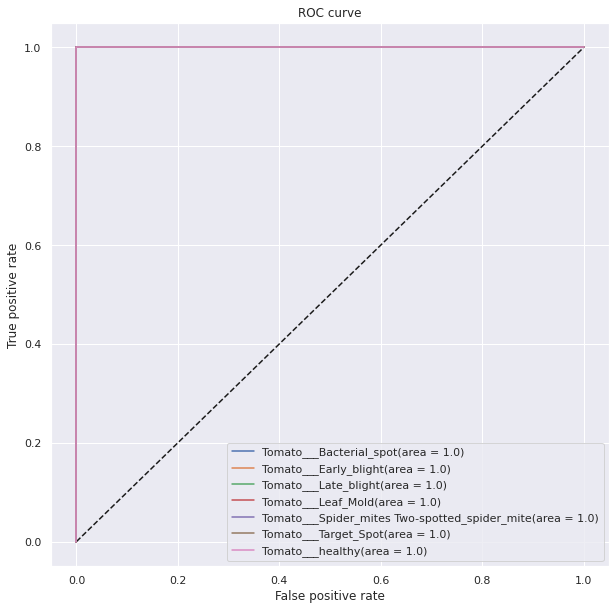

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(1, figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(len(label_binarizer.classes_)):
   fpr, tpr, thresholds = roc_curve(y_test[:, i], pred[:, i])
   individual_auc = auc(fpr, tpr)
   plt.plot(fpr, tpr, label= (label_binarizer.classes_[i] + '(area = {})'.format(individual_auc)))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

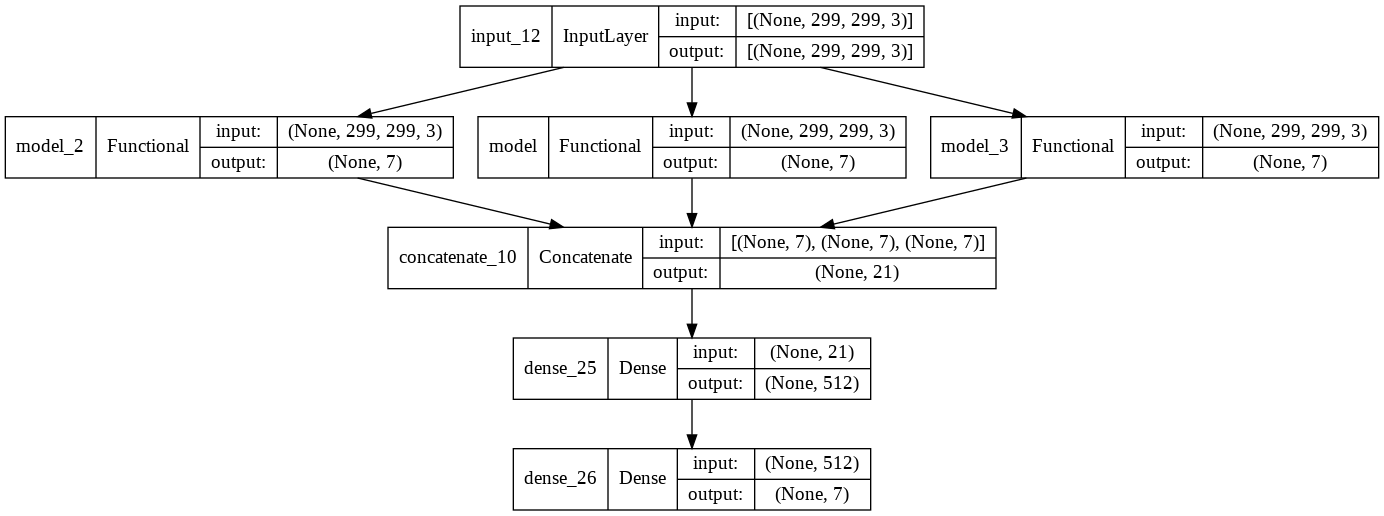

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(ensemble_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(ensemble_model)
tfmodel = converter.convert()
open('model_fix.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmph3vjtzjl/assets


147368280

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(deploy_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
open('model.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpn0we5cvm/assets


119479552